In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (roc_curve, classification_report, plot_roc_curve, f1_score, 
                             roc_auc_score, balanced_accuracy_score , accuracy_score, confusion_matrix, precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.inspection import permutation_importance
from sklearn.metrics import RocCurveDisplay
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import (norm, boxcox)
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold)
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

### 

In [2]:
data=pd.read_csv(r'C:\Users\spana\Documents\Project1\HotelRevenueMgm\Project3\data\aug_train.csv')

In [3]:
data = data.drop(['enrollee_id' , 'city'] , axis=1)
data

city_development_index gender      relevent_experience  \
0                       0.920   Male  Has relevent experience   
1                       0.776   Male   No relevent experience   
2                       0.624    NaN   No relevent experience   
3                       0.789    NaN   No relevent experience   
4                       0.767   Male  Has relevent experience   
...                       ...    ...                      ...   
19153                   0.878   Male   No relevent experience   
19154                   0.920   Male  Has relevent experience   
19155                   0.920   Male  Has relevent experience   
19156                   0.802   Male  Has relevent experience   
19157                   0.855    NaN   No relevent experience   

      enrolled_university education_level major_discipline experience  \
0           no_enrollment        Graduate             STEM        >20   
1           no_enrollment        Graduate             STEM         15   
2        Full time course        Graduate             STEM          5   
3                     NaN        Graduate  Business Degree         <1   
4           no_enrollment         Masters             STEM        >20   
...                   ...             ...              ...        ...   
19153       no_enrollment        Graduate       Humanities         14   
19154       no_enrollment        Graduate             STEM         14   
19155       no_enrollment        Graduate             STEM        >20   
19156       no_enrollment     High School              NaN         <1   
19157       no_enrollment  Primary School              NaN          2   

      company_size    company_type last_new_job  training_hours  target  
0              NaN             NaN            1              36     1.0  
1            50-99         Pvt Ltd           >4              47     0.0  
2              NaN             NaN        never              83     0.0  
3              NaN         Pvt Ltd        never              52     1.0  
4            50-99  Funded Startup            4               8     0.0  
...            ...             ...          ...             ...     ...  
19153          NaN             NaN            1              42     1.0  
19154          NaN             NaN            4              52     1.0  
19155        50-99         Pvt Ltd            4              44     0.0  
19156      500-999         Pvt Ltd            2              97     0.0  
19157          NaN             NaN            1             127     0.0  

[19158 rows x 12 columns]

### Let's see if our dataset is imbalance

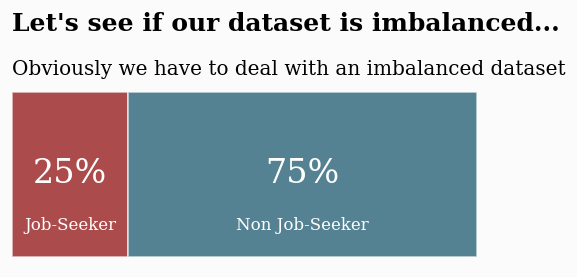

In [4]:
x=data.groupby(['target'])['target'].count()
y=len(data)
r=((x/y)).round(2)
ratio = pd.DataFrame(r).T


fig, ax = plt.subplots(1,1,figsize=(5, 2),dpi=120)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 

ax.barh(ratio.index, ratio[1.0], color='darkred', alpha=0.7, ec=background_color, label='Job-Seeker')
ax.barh(ratio.index, ratio[0.0], left=ratio[1.0], color="#0e4f66", alpha=0.7,ec=background_color, label='Non Job-Seeker')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.legend().set_visible(False)
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[1.0][i]*100)}%", xy=(ratio[1.0][i]/2, i),va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Job-Seeker", xy=(ratio[1.0][i]/2, -0.25),va = 'center', ha='center',fontsize=10, fontweight='light', fontfamily='serif',color='white')
    
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[0.0][i]*100)}%", xy=(ratio[1.0][i]+ratio[0.0][i]/2, i),va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Non Job-Seeker", xy=(ratio[1.0][i]+ratio[0.0][i]/2, -0.25),va = 'center', ha='center',fontsize=10, fontweight='light', fontfamily='serif',color='white')


fig.text(0.125,1.1,"Let's see if our dataset is imbalanced...", fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.915,'Obviously we have to deal with an imbalanced dataset',fontfamily='serif',fontsize=12)  


plt.show()

### Check for null values

In [5]:
null = data.isnull().sum().reset_index(name = 'Null Values')
null["Percentage"] = null["Null Values"].apply(lambda x: x/len(data)*100)
null = null[null['Null Values'] != 0]
null

index  Null Values  Percentage
1               gender         4508   23.530640
3  enrolled_university          386    2.014824
4      education_level          460    2.401086
5     major_discipline         2813   14.683161
6           experience           65    0.339284
7         company_size         5938   30.994885
8         company_type         6140   32.049274
9         last_new_job          423    2.207955

C:\Users\spana\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


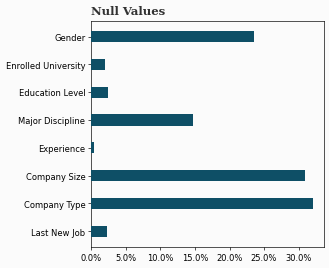

In [6]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(1,1,figsize=(5, 5),dpi=60)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 
ax.barh(np.arange(len(null.index)), null["Percentage"], zorder=3, color="#0e4f66", height=0.4)
ax.text(0, -0.8, 'Null Values', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(1))
ax.set_yticklabels(['Gender','Enrolled University','Education Level','Major Discipline' , 'Experience' , 'Company Size' ,
                   'Company Type' , 'Last New Job'])
ax.set_yticks(np.arange(len(null.index))+0. / 2)
ax.invert_yaxis();

## Preprocessing

In [7]:
#Replace '10/49' with '10-49'
data.company_size.replace(['10/49'], ['10-49'], inplace=True)

C:\Users\spana\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


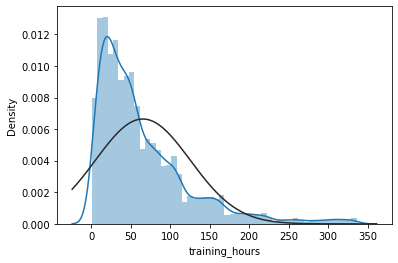

In [8]:
#'Training_hours doesn't follow normal distribution
sns.distplot(data["training_hours"], fit = norm)
plt.show()

C:\Users\spana\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


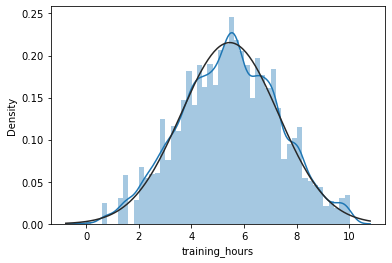

In [9]:
#Apply boxcox for transforming training_hours so that it closely resembles a normal distribution.
data["training_hours"], lam = boxcox(data["training_hours"])
sns.distplot(data["training_hours"], fit = norm)
plt.show()

In [10]:
#Create new catecogory to avoid drop null values
data['gender'].fillna('Not privided' , inplace = True)
data['company_type'].fillna('Unknown' , inplace = True)
data['company_size'].fillna('Unknown' , inplace = True)
data['major_discipline'].fillna('Unknown' , inplace = True)

In [11]:
data.isnull().sum()

city_development_index      0
gender                      0
relevent_experience         0
enrolled_university       386
education_level           460
major_discipline            0
experience                 65
company_size                0
company_type                0
last_new_job              423
training_hours              0
target                      0
dtype: int64

In [12]:
data.shape

(19158, 12)

In [13]:
data.dropna(inplace = True)
data.shape

(18014, 12)

In [14]:
#Change some values in order to convert the feature to numeric
data['experience'] = data['experience'].apply(lambda x: '0' if x == '<1' else x)
data['experience'] = data['experience'].apply(lambda x: '20' if x == '>20' else x)

In [15]:
data['experience'] = data['experience'].astype('int64')
data['training_hours'] = data['training_hours'].astype('int64')

In [16]:
#Change name
data.loc[data['enrolled_university'] == 'no_enrollment', 'enrolled_university'] = 'No Enrollment'

## More details about the imbalance dataset

C:\Users\spana\anaconda3\lib\site-packages\ipykernel_launcher.py:193: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 0, '')

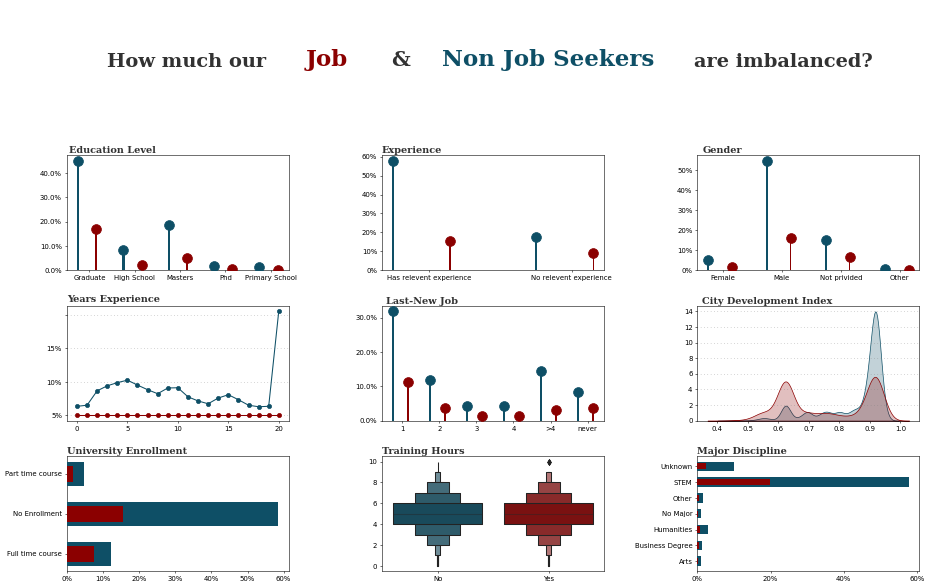

In [101]:
import matplotlib.ticker as mtick
background_color = 'white'
fig = plt.figure(figsize = (22,15) , dpi = 50)
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(4,3)
gs.update(wspace=0.42, hspace=0.31)
ax0 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[1 , 1])
ax2 = fig.add_subplot(gs[1 , 2])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[2, 2])
ax6 = fig.add_subplot(gs[3, 0])
ax7 = fig.add_subplot(gs[3, 1])
ax8 = fig.add_subplot(gs[3, 2])
ax9 = fig.add_subplot(gs[0, :])


########EDUCATION-LEVEL################

non_job_seeker1=data.loc[(data['target']==0.0)]
educ1 = pd.DataFrame(non_job_seeker1['education_level'].value_counts())
educ1["Percentage"] = educ1["education_level"].apply(lambda x: x/(len(data))*100)
educ1 = educ1.sort_index()

job_seeker1=data.loc[(data['target']==1.0)]
educ2 = pd.DataFrame(job_seeker1['education_level'].value_counts())
educ2["Percentage"] = educ2["education_level"].apply(lambda x: x/(len(data))*100)
educ2 = educ2.sort_index()


ax0.bar(np.arange(len(educ1.index)), height=educ1["Percentage"], zorder=3, color="#0e4f66", width=0.05)
ax0.scatter(np.arange(len(educ1.index)), educ1["Percentage"], zorder=3,s=200, color="#0e4f66")
ax0.bar(np.arange(len(educ2.index))+0.4, height=educ2["Percentage"], zorder=3, color="darkred", width=0.05)
ax0.scatter(np.arange(len(educ2.index))+0.4, educ2["Percentage"], zorder=3,s=200, color="darkred")
ax0.text(-0.20, 48.5, 'Education Level', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
ax0.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax0.set_xticks(np.arange(len(educ2.index))+0.5 / 2)
ax0.set_xticklabels(list(educ2.index),rotation=0)

################LAST-NEW JOB#############

non_job_seeker1=data.loc[(data['target']==0.0)]
last1 = pd.DataFrame(non_job_seeker1['last_new_job'].value_counts())
last1["Percentage"] = last1["last_new_job"].apply(lambda x: x/(len(data))*100)
last1 = last1.sort_index()

job_seeker1=data.loc[(data['target']==1.0)]
last2 = pd.DataFrame(job_seeker1['last_new_job'].value_counts())
last2["Percentage"] = last2["last_new_job"].apply(lambda x: x/(len(data))*100)
last2 = last2.sort_index()


ax4.bar(np.arange(len(last1.index)), height=last1["Percentage"], zorder=3, color="#0e4f66", width=0.05)
ax4.scatter(np.arange(len(last1.index)), last1["Percentage"], zorder=3,s=200, color="#0e4f66")
ax4.bar(np.arange(len(last2.index))+0.4, height=last2["Percentage"], zorder=3, color="darkred", width=0.05)
ax4.scatter(np.arange(len(last2.index))+0.4, last2["Percentage"], zorder=3,s=200, color="darkred")
ax4.text(-0.20, 34.0, 'Last-New Job', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax4.yaxis.set_major_formatter(mtick.PercentFormatter())
ax4.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax4.set_xticks(np.arange(len(last2.index))+0.5 / 2)
ax4.set_xticklabels(list(last2.index),rotation=0)

###############TEXT##################

ax9.spines[["left" , "bottom" , "right" , "top"]].set_visible(False)
ax9.tick_params(left=False, bottom=False)
ax9.set_xticklabels([])
ax9.set_yticklabels([])
ax9.text(0.14, 0.5, 'How much our', horizontalalignment='center', verticalalignment='center',fontsize=28, fontweight='bold', fontfamily='serif', color="#323232")
ax9.text(0.28,0.47,"Job", fontweight="bold", fontfamily='serif', fontsize=33, color='darkred')
ax9.text(0.38,0.47,"&", fontweight="bold", fontfamily='serif', fontsize=30, color='#323232')
ax9.text(0.44,0.47,"Non Job Seekers", fontweight="bold", fontfamily='serif', fontsize=33, color='#0e4f66')
ax9.text(0.84, 0.5, 'are imbalanced?', horizontalalignment='center', verticalalignment='center',fontsize=28, fontweight='bold', fontfamily='serif', color="#323232")

###############EXPERIENCE####################

non_job_seeker2=data.loc[(data.target==0.0)]
exp1 = pd.DataFrame(non_job_seeker2['relevent_experience'].value_counts())
exp1["Percentage"] = exp1["relevent_experience"].apply(lambda x: x/(len(data))*100)
exp1 = exp1.sort_index()

job_seeker3=data.loc[(data['target']==1.0)]
exp2 = pd.DataFrame(job_seeker3['relevent_experience'].value_counts())
exp2["Percentage"] = exp2["relevent_experience"].apply(lambda x: x/(len(data))*100)
exp2 = exp2.sort_index()


ax1.bar(np.arange(len(exp1.index)), height=exp1["Percentage"], zorder=3, color="#0e4f66", width=0.01)
ax1.scatter(np.arange(len(exp1.index)), exp1["Percentage"], zorder=3,s=200, color="#0e4f66")
ax1.bar(np.arange(len(exp2.index))+0.4, height=exp2["Percentage"], zorder=3, color="darkred", width=0.01)
ax1.scatter(np.arange(len(exp2.index))+0.4, exp2["Percentage"], zorder=3,s=200, color="darkred")
ax1.text(-0.08, 62.0, 'Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax1.set_xticks(np.arange(len(exp2.index))+0.5 / 2)
ax1.set_xticklabels(list(exp2.index),rotation=0)

#####################GENDER####################

non_job_seeker3=data.loc[(data.target==0.0)]
gender1 = pd.DataFrame(non_job_seeker3['gender'].value_counts())
gender1["Percentage"] = gender1["gender"].apply(lambda x: x/(len(data))*100)
gender1 = gender1.sort_index()

job_seeker4=data.loc[(data['target']==1.0)]
gender2 = pd.DataFrame(job_seeker4['gender'].value_counts())
gender2["Percentage"] = gender2["gender"].apply(lambda x: x/(len(data))*100)
gender2 = gender2.sort_index()


ax2.bar(np.arange(len(gender1.index)), height=gender1["Percentage"], zorder=3, color="#0e4f66", width=0.02)
ax2.scatter(np.arange(len(gender1.index)), gender1["Percentage"], zorder=3,s=200, color="#0e4f66")
ax2.bar(np.arange(len(gender2.index))+0.4, height=gender2["Percentage"], zorder=3, color="darkred", width=0.02)
ax2.scatter(np.arange(len(gender2.index))+0.4, gender2["Percentage"], zorder=3,s=200, color="darkred")
ax2.text(-0.1, 59.0, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax2.set_xticks(np.arange(len(gender2.index))+0.5 / 2)
ax2.set_xticklabels(list(gender2.index),rotation=0)

###########ENROLLED-UNIVERSITY###################

non_job_seeker5=data.loc[(data.target==0.0)]
univ1 = pd.DataFrame(non_job_seeker5['enrolled_university'].value_counts())
univ1["Percentage"] = univ1["enrolled_university"].apply(lambda x: x/(len(data))*100)
univ1 = univ1.sort_index()

job_seeker6=data.loc[(data['target']==1.0)]
univ2 = pd.DataFrame(job_seeker6['enrolled_university'].value_counts())
univ2["Percentage"] = univ2["enrolled_university"].apply(lambda x: x/(len(data))*100)
univ2 = univ2.sort_index()



ax6.text(0, 2.5, 'University Enrollment', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax6.barh(univ1.index, univ1['Percentage'], color="#0e4f66", zorder=3, height=0.6)
ax6.barh(univ2.index, univ2['Percentage'], color="darkred", zorder=3, height=0.4)
ax6.xaxis.set_major_formatter(mtick.PercentFormatter())
ax6.xaxis.set_major_locator(mtick.MultipleLocator(10))

################TRAINING-HOURS###################

non_job_seeker7=data.loc[(data.target==0.0)]
hours1 = pd.DataFrame(non_job_seeker7['training_hours'])
hours1["All"] = "No"

job_seeker8=data.loc[(data['target']==1.0)]
hours2 = pd.DataFrame(job_seeker8['training_hours'])
hours2["All"] = "Yes"


ax7.text(-0.5,10.7, 'Training Hours', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
comb_graph_temp_df = pd.concat([hours1, hours2] , axis=0)
sns.boxenplot(ax=ax7, y="training_hours", x = 'All' , data=comb_graph_temp_df, palette=["#0e4f66", "darkred"])
ax7.set_xlabel("")
ax7.set_ylabel("")

#############MAJOR-DISCIPLINE####################

non_job_seeker9=data.loc[(data.target==0.0)]
major1 = pd.DataFrame(non_job_seeker9['major_discipline'].value_counts())
major1["Percentage"] = major1["major_discipline"].apply(lambda x: x/(len(data))*100)
major1 = major1.sort_index()

job_seeker10=data.loc[(data['target']==1.0)]
major2 = pd.DataFrame(job_seeker10['major_discipline'].value_counts())
major2["Percentage"] = major2["major_discipline"].apply(lambda x: x/(len(data))*100)
major2 = major2.sort_index()


ax8.text(0, 6.8, 'Major Discipline', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.barh(major1.index, major1['Percentage'], color="#0e4f66", zorder=3, height=0.6)
ax8.barh(major2.index, major2['Percentage'], color="darkred", zorder=3, height=0.4)
ax8.xaxis.set_major_formatter(mtick.PercentFormatter())
ax8.xaxis.set_major_locator(mtick.MultipleLocator(20))

################YEARS OF EXPERIENCE################

non_job_seeker11=data.loc[(data.target==0.0)]
exp1 = pd.DataFrame(non_job_seeker11["experience"].value_counts())
exp1["Percentage"] = exp1["experience"].apply(lambda x: x/(len(data))*100)
exp1 = exp1.sort_index()

job_seeker11=data.loc[(data['target']==1.0)]
exp2 = pd.DataFrame(job_seeker11["experience"].value_counts())
exp2["Percentage"] = round(exp2["experience"].apply(lambda x: x/(len(data)))).astype(int)
exp2 = exp2.sort_index()


ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.plot(exp1.index, exp1["Percentage"], zorder=3, color="#0e4f66", marker='o')
ax3.plot(exp2.index, exp2["Percentage"], zorder=3, color="darkred", marker='o')
ax3.text(-1.0, 17.0, 'Years Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.set_yticklabels(labels = ['0  ', '5%','10%','15%'])
ax3.xaxis.set_major_locator(mtick.MultipleLocator(5))
ax3.yaxis.set_major_locator(mtick.MultipleLocator(5))

#############CITY-DEVELOPMENT-INDEX####################

ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
non_job_seeker12=data.loc[(data.target==0.0)]
city1 = pd.DataFrame(non_job_seeker12["city_development_index"])

job_seeker12=data.loc[(data['target']==1.0)]
city2 = pd.DataFrame(job_seeker12["city_development_index"])


sns.kdeplot(city1["city_development_index"], ax=ax5,color="#0e4f66", shade=True, label="Train")
sns.kdeplot(city2["city_development_index"], ax=ax5, color="darkred", shade=True, label="Test")
ax5.text(0.35, 15, 'City Development Index', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax5.set_ylabel('')    
ax5.set_xlabel('')


In [18]:
data1=pd.get_dummies(data)
data1

city_development_index  experience  training_hours  target  \
0                       0.920          20               4     1.0   
1                       0.776          15               5     0.0   
2                       0.624           5               6     0.0   
4                       0.767          20               2     0.0   
5                       0.764          11               4     1.0   
...                       ...         ...             ...     ...   
19153                   0.878          14               5     1.0   
19154                   0.920          14               5     1.0   
19155                   0.920          20               5     0.0   
19156                   0.802           0               6     0.0   
19157                   0.855           2               7     0.0   

       gender_Female  gender_Male  gender_Not privided  gender_Other  \
0                  0            1                    0             0   
1                  0            1                    0             0   
2                  0            0                    1             0   
4                  0            1                    0             0   
5                  0            0                    1             0   
...              ...          ...                  ...           ...   
19153              0            1                    0             0   
19154              0            1                    0             0   
19155              0            1                    0             0   
19156              0            1                    0             0   
19157              0            0                    1             0   

       relevent_experience_Has relevent experience  \
0                                                1   
1                                                0   
2                                                0   
4                                                1   
5                                                1   
...                                            ...   
19153                                            0   
19154                                            1   
19155                                            1   
19156                                            1   
19157                                            0   

       relevent_experience_No relevent experience  ...  company_type_Other  \
0                                               0  ...                   0   
1                                               1  ...                   0   
2                                               1  ...                   0   
4                                               0  ...                   0   
5                                               0  ...                   0   
...                                           ...  ...                 ...   
19153                                           1  ...                   0   
19154                                           0  ...                   0   
19155                                           0  ...                   0   
19156                                           0  ...                   0   
19157                                           1  ...                   0   

       company_type_Public Sector  company_type_Pvt Ltd  company_type_Unknown  \
0                               0                     0                     1   
1                               0                     1                     0   
2                               0                     0                     1   
4                               0                     0                     0   
5                               0                     0                     1   
...                           ...                   ...                   ...   
19153                           0                     0                     1   
19154                           0                     0                     1  

## First Trials

In [19]:
Models10 = pd.DataFrame(columns=['Algorithm','Model Score','Precision','Recall','F1 score','ROC-AUC score'])
models = [LogisticRegression() , RandomForestClassifier() , KNeighborsClassifier() , AdaBoostClassifier() , GradientBoostingClassifier()]
X = data1.drop('target', axis=1)
y = data1['target']
X1_train , X1_test , y1_train , y1_test = train_test_split(X , y , test_size = 0.2 , random_state=45)
for i in models:
    i.fit(X1_train , y1_train)
    preds = i.predict(X1_test)
    print(i)
    print(classification_report(y1_test, preds))
    
    model10 = {}

    model10['Algorithm'] = str(i)
    model10['Model Score'] = str(round((accuracy_score(y1_test, preds)*100),2)) + "%"
    model10['Precision'] = round(precision_score(y1_test, preds),2)
    model10['Recall'] = round(recall_score(y1_test, preds),2)
    model10['F1 score'] = round(f1_score(y1_test, preds),2)
    model10['ROC-AUC score'] = round(roc_auc_score(y1_test, preds),2)
    Models10 = Models10.append(model10,ignore_index=True)

C:\Users\spana\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86      2712
         1.0       0.55      0.23      0.32       891

    accuracy                           0.76      3603
   macro avg       0.67      0.58      0.59      3603
weighted avg       0.73      0.76      0.72      3603

RandomForestClassifier()
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      2712
         1.0       0.56      0.45      0.50       891

    accuracy                           0.78      3603
   macro avg       0.70      0.67      0.68      3603
weighted avg       0.76      0.78      0.77      3603

KNeighborsClassifier()
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84      2712
         1.0       0.49      0.35      0.41       891

    accuracy                           0.75      3603
   macro avg       0.64      0.61      0.62      3603
weigh

### Results for simple trials

In [20]:
Models10

Algorithm Model Score  Precision  Recall  F1 score  \
0          LogisticRegression()       76.3%       0.55    0.23      0.32   
1      RandomForestClassifier()      77.74%       0.56    0.45      0.50   
2        KNeighborsClassifier()      74.74%       0.49    0.35      0.41   
3          AdaBoostClassifier()      78.16%       0.61    0.33      0.43   
4  GradientBoostingClassifier()       80.1%       0.61    0.56      0.58   

   ROC-AUC score  
0           0.58  
1           0.67  
2           0.61  
3           0.63  
4           0.72

#### We will continue the analysis with Random Forest and Gradient Boosting Classifiers

## RandomizedSearchCV--StratifiedKFold--SMOTE

In [21]:
from sklearn.metrics import mean_absolute_error
Models = pd.DataFrame(columns=['Algorithm','Model Score','Precision','Recall','F1 score','ROC-AUC score'])

#Define the function's arguments
def taining_without_feature_selection(Parameters, Model, Dataframe, Modelname , Color):
    
    data1 = Dataframe.copy()
    
    #Define X , y
    X = data1.drop('target', axis=1)
    y = data1['target']
    
    #Traditional split of the dataset 80% - 20%
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

    #Proportional split of 80% data with respect to the class of the target feature ie. [1,0]
    #Try to formulate in the best possible way my train set using StratifiedKFold for maintaining the analogy of minority-majority class
    sf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    print(sf)
    print(sf.split(x_train, y_train))

    for train_index, test_index in sf.split(x_train, y_train):
#         print(train_index)
#         print(test_index)
        sf_x_train, sf_x_test = X.iloc[train_index], X.iloc[test_index]
        sf_y_train, sf_y_test = y.iloc[train_index], y.iloc[test_index]
        
    sf_x_train, sf_x_test, sf_y_train, sf_y_test = sf_x_train.values, sf_x_test.values, sf_y_train.values, sf_y_test.values
    
    model_parameter_sm = Parameters

    rand_model = RandomizedSearchCV(Model, model_parameter_sm, n_iter=4)
    print(rand_model)
     
    #Identifying the best parameters through RandomizedSearchCV() using sf_x_train , sf_y_train that we have already formulate in StratifiedKFold
    for train, test in sf.split(sf_x_train, sf_y_train):
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_model) 
        fitting_model = pipeline.fit(sf_x_train[train], sf_y_train[train])
        best_model = rand_model.best_estimator_
        print(best_model)

    #Evaluation with against 20% unseen testing data
    print()
    print("Evaluation Of Models")  

    sm = SMOTE(sampling_strategy='minority', random_state=42)
    Xsm_train, ysm_train = sm.fit_resample(sf_x_train, sf_y_train)
    print()
    print("Random Model Evaluation")  
    
    final_model_sm = rand_model.best_estimator_
    print(final_model_sm)
    final_model_sm.fit(Xsm_train, ysm_train)
    train = final_model_sm.predict(Xsm_train)
    train_acc = accuracy_score(ysm_train , train)
    print(train_acc)


    prediction = final_model_sm.predict(x_test)
    preds_acc = accuracy_score(y_test , prediction)
    print(preds_acc)

    print(classification_report(y_test, prediction))
    

    model = {}

    model['Algorithm'] = Modelname
    model['Model Score'] = str(round((accuracy_score(y_test, prediction)*100),2)) + "%"
    model['Precision'] = round(precision_score(y_test, prediction),2)
    model['Recall'] = round(recall_score(y_test, prediction),2)
    model['F1 score'] = round(f1_score(y_test, prediction),2)
    model['ROC-AUC score'] = round(roc_auc_score(y_test, prediction),2)


    ax = plt.gca()
    plt.title('ROC Plot')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    RocCurveDisplay.from_estimator(final_model_sm, x_test, y_test, ax=ax , label=(Modelname , model['ROC-AUC score']) , alpha=0.8 , color=Color)


    return model


StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
<generator object _BaseKFold.split at 0x000001BD2EF1D348>
RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=4,
                   param_distributions={'learning_rate': [0.001, 0.01, 1],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})
GradientBoostingClassifier(learning_rate=1, n_estimators=300)
GradientBoostingClassifier(learning_rate=1, n_estimators=300)
GradientBoostingClassifier(learning_rate=1, n_estimators=200)
GradientBoostingClassifier(learning_rate=0.01, n_estimators=400)
GradientBoostingClassifier(learning_rate=1, n_estimators=200)

Evaluation Of Models

Random Model Evaluation
GradientBoostingClassifier(learning_rate=1, n_estimators=200)
0.904247990815155
0.819872328615043
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      2704
         1.0       0.65     

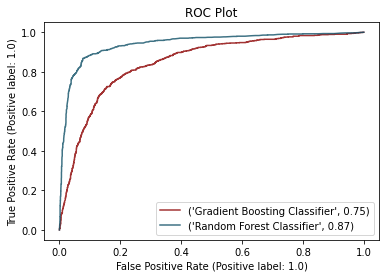

In [22]:
TrainedModel = taining_without_feature_selection({"n_estimators": [100, 200, 300, 400, 500], "learning_rate":[0.001,0.01,1]}, GradientBoostingClassifier(), data1, "Gradient Boosting Classifier" , Color = 'darkred')
Models = Models.append(TrainedModel,ignore_index=True)
TrainedModel = taining_without_feature_selection({"max_depth": [3, 5, 10, None],"n_estimators": [100, 200 , 300, 400, 500]},  RandomForestClassifier(), data1, "Random Forest Classifier" , Color = '#0e4f66')
Models = Models.append(TrainedModel,ignore_index=True)

In [23]:
Models.sort_values('F1 score',ascending=False)
Models

Algorithm Model Score  Precision  Recall  F1 score  \
0  Gradient Boosting Classifier      81.99%       0.65    0.61      0.63   
1      Random Forest Classifier      90.81%       0.82    0.81      0.81   

   ROC-AUC score  
0           0.75  
1           0.87

## Let's try Select KBest

In [24]:
Models = pd.DataFrame(columns=['Algorithm','Model Score','Precision','Recall','F1 score','ROC-AUC score'])

def taining_with_feature_selection(Parameters, Model, Dataframe, Modelname):
    
    data1 = Dataframe.copy()
    
    X = data1.drop('target', axis=1)
    y = data1['target']
    
    '''
    Feature Selection Process: 
    class sklearn.feature_selection.SelectKBest(score_func=<function>, k=<number of features>
        score_func - Scoring measure
        k - Total features to be returned 
    '''
    
    fs = SelectKBest(score_func=f_classif, k=int((data.shape[1]*85)/100))

    X = fs.fit_transform(X, y)
    
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

    sf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    for train_index, test_index in sf.split(x_train, y_train):
        sf_x_train, sf_x_test = X.iloc[train_index], X.iloc[test_index]
        sf_y_train, sf_y_test = y.iloc[train_index], y.iloc[test_index]

    sf_x_train, sf_x_test, sf_y_train, sf_y_test = sf_x_train.values, sf_x_test.values, sf_y_train.values, sf_y_test.values
    
    model_parameter_sm = Parameters

    rand_model = RandomizedSearchCV(Model, model_parameter_sm, n_iter=4)

    for train, test in sf.split(sf_x_train, sf_y_train):
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_model) 
        fitting_model = pipeline.fit(sf_x_train[train], sf_y_train[train])
        best_model = rand_model.best_estimator_

    print()
    print("Evaluation Of Models")  
    sm = SMOTE(sampling_strategy='minority', random_state=42)
    Xsm_train, ysm_train = sm.fit_resample(sf_x_train, sf_y_train)
    
    print()
    print("Random Model Evaluation")  
    
    final_model_sm = rand_model.best_estimator_
    final_model_sm.fit(Xsm_train, ysm_train)

    prediction = final_model_sm.predict(x_test)
    print(classification_report(y_test, prediction))
   
    
    model = {}

    model['Algorithm'] = Modelname
    model['Model Score'] = str(round((accuracy_score(y_test, prediction)*100),2)) + "%"
    model['Precision'] = round(precision_score(y_test, prediction),2)
    model['Recall'] = round(recall_score(y_test, prediction),2)
    model['F1 score'] = round(f1_score(y_test, prediction),2)
    model['ROC-AUC score'] = round(roc_auc_score(y_test, prediction),2)
    
    ax = plt.gca()
    plt.title('ROC Plot')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   # plt.legend()
    RocCurveDisplay.from_estimator(final_model_sm, x_test, y_test, ax=ax, label=(Modelname , model['ROC-AUC score']) , alpha=0.8)
    
    
    return model


Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.88      2704
         1.0       0.62      0.65      0.64       899

    accuracy                           0.81      3603
   macro avg       0.75      0.76      0.76      3603
weighted avg       0.82      0.81      0.82      3603


Evaluation Of Models

Random Model Evaluation
              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85      2704
         1.0       0.56      0.72      0.63       899

    accuracy                           0.79      3603
   macro avg       0.73      0.77      0.74      3603
weighted avg       0.81      0.79      0.80      3603



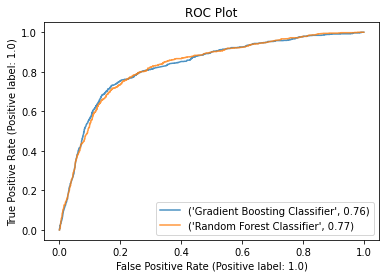

In [25]:
TrainedModel = taining_with_feature_selection({"n_estimators": [100, 200, 300, 400, 500], "learning_rate":[0.001,0.01,1]}, GradientBoostingClassifier(), data1, "Gradient Boosting Classifier")
ModelsKBest = Models.append(TrainedModel,ignore_index=True)
TrainedModel = taining_with_feature_selection({"max_depth": [3, 5, 10, None],"n_estimators": [100, 200 , 300, 400, 500]},  RandomForestClassifier(), data1, "Random Forest Classifier")
ModelsKbest = ModelsKBest.append(TrainedModel,ignore_index=True)

In [26]:
ModelsKBest.sort_values('F1 score',ascending=False)
ModelsKBest

Algorithm Model Score  Precision  Recall  F1 score  \
0  Gradient Boosting Classifier      81.46%       0.62    0.65      0.64   

   ROC-AUC score  
0           0.76

### Let's try to drop outliers with 2 methods

## Local Outlier Factor

In [27]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [28]:
local = pd.DataFrame(data1) 

In [29]:
#Fit LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=6)
local['anomaly_label']=lof.fit_predict(data1)

In [30]:
#Keep only rows with anomaly_label=1
local1 = local.loc[local['anomaly_label'] == 1]
local1

city_development_index  experience  training_hours  target  \
0                       0.920          20               4     1.0   
1                       0.776          15               5     0.0   
2                       0.624           5               6     0.0   
4                       0.767          20               2     0.0   
5                       0.764          11               4     1.0   
...                       ...         ...             ...     ...   
19152                   0.920           7               4     0.0   
19153                   0.878          14               5     1.0   
19154                   0.920          14               5     1.0   
19156                   0.802           0               6     0.0   
19157                   0.855           2               7     0.0   

       gender_Female  gender_Male  gender_Not privided  gender_Other  \
0                  0            1                    0             0   
1                  0            1                    0             0   
2                  0            0                    1             0   
4                  0            1                    0             0   
5                  0            0                    1             0   
...              ...          ...                  ...           ...   
19152              1            0                    0             0   
19153              0            1                    0             0   
19154              0            1                    0             0   
19156              0            1                    0             0   
19157              0            0                    1             0   

       relevent_experience_Has relevent experience  \
0                                                1   
1                                                0   
2                                                0   
4                                                1   
5                                                1   
...                                            ...   
19152                                            1   
19153                                            0   
19154                                            1   
19156                                            1   
19157                                            0   

       relevent_experience_No relevent experience  ...  \
0                                               0  ...   
1                                               1  ...   
2                                               1  ...   
4                                               0  ...   
5                                               0  ...   
...                                           ...  ...   
19152                                           0  ...   
19153                                           1  ...   
19154                                           0  ...   
19156                                           0  ...   
19157                                           1  ...   

       company_type_Public Sector  company_type_Pvt Ltd  company_type_Unknown  \
0                               0                     0                     1   
1                               0                     1                     0   
2                               0                     0                     1   
4                               0                     0                     0   
5                               0                     0                     1   
...                           ...                   ...                   ...   
19152                           0                     0                     0   
19153                           0                     0                     1   
19154                           0                     0                     1   
19156                           0                     1                     0   
19157                           0                     0                     

In [31]:
#Drop the 'anomaly_label' column
local1.drop(['anomaly_label'], axis=1, inplace=True)
local1

C:\Users\spana\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


city_development_index  experience  training_hours  target  \
0                       0.920          20               4     1.0   
1                       0.776          15               5     0.0   
2                       0.624           5               6     0.0   
4                       0.767          20               2     0.0   
5                       0.764          11               4     1.0   
...                       ...         ...             ...     ...   
19152                   0.920           7               4     0.0   
19153                   0.878          14               5     1.0   
19154                   0.920          14               5     1.0   
19156                   0.802           0               6     0.0   
19157                   0.855           2               7     0.0   

       gender_Female  gender_Male  gender_Not privided  gender_Other  \
0                  0            1                    0             0   
1                  0            1                    0             0   
2                  0            0                    1             0   
4                  0            1                    0             0   
5                  0            0                    1             0   
...              ...          ...                  ...           ...   
19152              1            0                    0             0   
19153              0            1                    0             0   
19154              0            1                    0             0   
19156              0            1                    0             0   
19157              0            0                    1             0   

       relevent_experience_Has relevent experience  \
0                                                1   
1                                                0   
2                                                0   
4                                                1   
5                                                1   
...                                            ...   
19152                                            1   
19153                                            0   
19154                                            1   
19156                                            1   
19157                                            0   

       relevent_experience_No relevent experience  ...  company_type_Other  \
0                                               0  ...                   0   
1                                               1  ...                   0   
2                                               1  ...                   0   
4                                               0  ...                   0   
5                                               0  ...                   0   
...                                           ...  ...                 ...   
19152                                           0  ...                   0   
19153                                           1  ...                   0   
19154                                           0  ...                   0   
19156                                           0  ...                   0   
19157                                           1  ...                   0   

       company_type_Public Sector  company_type_Pvt Ltd  company_type_Unknown  \
0                               0                     0                     1   
1                               0                     1                     0   
2                               0                     0                     1   
4                               0                     0                     0   
5                               0                     0                     1   
...                           ...                   ...                   ...   
19152                           0                     0                     0   
19153                           0                     0                     1  

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
<generator object _BaseKFold.split at 0x000001BD3048B948>
RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=4,
                   param_distributions={'learning_rate': [0.001, 0.01, 1],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})
GradientBoostingClassifier(learning_rate=1, n_estimators=500)
GradientBoostingClassifier(learning_rate=1, n_estimators=200)
GradientBoostingClassifier(learning_rate=1, n_estimators=300)
GradientBoostingClassifier(learning_rate=1, n_estimators=300)
GradientBoostingClassifier(learning_rate=0.01, n_estimators=400)

Evaluation Of Models

Random Model Evaluation
GradientBoostingClassifier(learning_rate=0.01, n_estimators=400)
0.8049562322771545
0.7698695136417556
              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      2548
         1.0       0.52

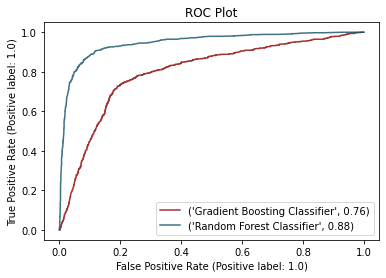

In [32]:
TrainedModel = taining_without_feature_selection({"n_estimators": [100, 200, 300, 400, 500], "learning_rate":[0.001,0.01,1]}, GradientBoostingClassifier(), local1, "Gradient Boosting Classifier" , Color = 'darkred')
ModelsLocal = Models.append(TrainedModel,ignore_index=True)
TrainedModel = taining_without_feature_selection({"max_depth": [3, 5, 10, None],"n_estimators": [100, 200 , 300, 400, 500]},  RandomForestClassifier(), local1, "Random Forest Classifier" , Color = '#0e4f66')
ModelsLocal = ModelsLocal.append(TrainedModel,ignore_index=True)

In [33]:
ModelsLocal.sort_values('F1 score',ascending=False)
ModelsLocal

Algorithm Model Score  Precision  Recall  F1 score  \
0  Gradient Boosting Classifier      76.99%       0.52    0.75      0.62   
1      Random Forest Classifier      91.01%       0.82    0.81      0.82   

   ROC-AUC score  
0           0.76  
1           0.88

### It doesn't seem to help out models , so let's check the Isolation Forest

## Isolation Forest

In [34]:
#Fit Isolation Forest
iforest = IsolationForest()
pred = iforest.fit_predict(data1)

In [35]:
#New columns for 'scores' and 'anomaly_label'
data1['scores'] = iforest.decision_function(data1)
data1['anomaly_label'] = pred

In [36]:
#Keep only rows with anomaly_label=1
data2 = data1.loc[data1['anomaly_label'] == 1]
data2

city_development_index  experience  training_hours  target  \
0                       0.920          20               4     1.0   
1                       0.776          15               5     0.0   
2                       0.624           5               6     0.0   
4                       0.767          20               2     0.0   
5                       0.764          11               4     1.0   
...                       ...         ...             ...     ...   
19152                   0.920           7               4     0.0   
19153                   0.878          14               5     1.0   
19154                   0.920          14               5     1.0   
19155                   0.920          20               5     0.0   
19156                   0.802           0               6     0.0   

       gender_Female  gender_Male  gender_Not privided  gender_Other  \
0                  0            1                    0             0   
1                  0            1                    0             0   
2                  0            0                    1             0   
4                  0            1                    0             0   
5                  0            0                    1             0   
...              ...          ...                  ...           ...   
19152              1            0                    0             0   
19153              0            1                    0             0   
19154              0            1                    0             0   
19155              0            1                    0             0   
19156              0            1                    0             0   

       relevent_experience_Has relevent experience  \
0                                                1   
1                                                0   
2                                                0   
4                                                1   
5                                                1   
...                                            ...   
19152                                            1   
19153                                            0   
19154                                            1   
19155                                            1   
19156                                            1   

       relevent_experience_No relevent experience  ...  company_type_Pvt Ltd  \
0                                               0  ...                     0   
1                                               1  ...                     1   
2                                               1  ...                     0   
4                                               0  ...                     0   
5                                               0  ...                     0   
...                                           ...  ...                   ...   
19152                                           0  ...                     0   
19153                                           1  ...                     0   
19154                                           0  ...                     0   
19155                                           0  ...                     1   
19156                                           0  ...                     1   

       company_type_Unknown  last_new_job_1  last_new_job_2  last_new_job_3  \
0                         1               1               0               0   
1                         0               0               0               0   
2                         1               0               0               0   
4                         0               0               0               0   
5                         1               1               0               0   
...                     ...             ...             ...             ...   
19152                     0               1               0               0   
19153                     1               1               0            

In [37]:
#Drop the 'anomaly_label' column
data2.drop(['anomaly_label'], axis=1, inplace=True)

C:\Users\spana\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
<generator object _BaseKFold.split at 0x000001BD2EF419C8>
RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=4,
                   param_distributions={'learning_rate': [0.001, 0.01, 1],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})
GradientBoostingClassifier(learning_rate=1, n_estimators=300)
GradientBoostingClassifier(learning_rate=1, n_estimators=400)
GradientBoostingClassifier(learning_rate=1, n_estimators=300)
GradientBoostingClassifier(learning_rate=1, n_estimators=200)
GradientBoostingClassifier(learning_rate=1)

Evaluation Of Models

Random Model Evaluation
GradientBoostingClassifier(learning_rate=1)
0.939550313306303
0.8870919436957173
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      2494
         1.0       0.78      0.78      0.78       845

    accurac

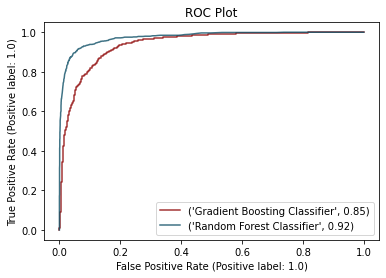

In [38]:
TrainedModel = taining_without_feature_selection({"n_estimators": [100, 200, 300, 400, 500], "learning_rate":[0.001,0.01,1]}, GradientBoostingClassifier(), data2, "Gradient Boosting Classifier" , Color = 'darkred')
ModelsIsolation = Models.append(TrainedModel,ignore_index=True)
TrainedModel = taining_without_feature_selection({"max_depth": [3, 5, 10, None],"n_estimators": [100, 200 , 300, 400, 500]},  RandomForestClassifier(), data2, "Random Forest Classifier" , Color = '#0e4f66')
ModelsIsolation = ModelsIsolation.append(TrainedModel,ignore_index=True)

In [39]:
ModelsIsolation.sort_values('F1 score',ascending=False)
ModelsIsolation

Algorithm Model Score  Precision  Recall  F1 score  \
0  Gradient Boosting Classifier      88.71%       0.78    0.78      0.78   
1      Random Forest Classifier      93.98%       0.89    0.88      0.88   

   ROC-AUC score  
0           0.85  
1           0.92